#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Data preprocessing

Necessary imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Set random seed, separate from torch one

In [3]:
np.random.seed(42)

### Loading train and test datasets

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

How to load the data:

In [4]:
df = pd.read_csv('regression_dataset/train_data.csv')

In [5]:
test_df = pd.read_csv('regression_dataset/test_data.csv')

See how many samples there are and other info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   100 non-null    float64
 1   label   100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   100 non-null    float64
 1   label   100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


### Looking at training data

How to get a specific sample:

In [8]:
sample_index = 0
input = df.iloc[sample_index]['input']
label = df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

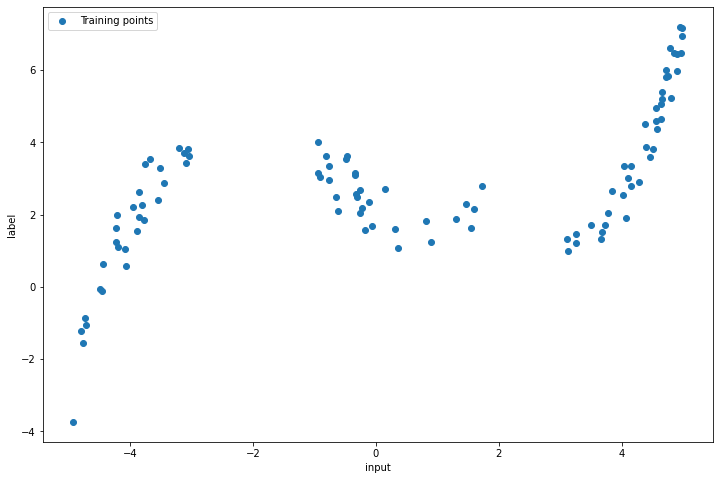

In [9]:
fig = plt.figure(figsize=(12,8))
plt.scatter(df.input, df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

### Splitting train to train and val

In [10]:
from sklearn.model_selection import train_test_split, KFold

*   We arbitrarily set validation set to be 25% of the dataset, which means it will be 25 samples.

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df.input, df.label, test_size=0.25)

In [13]:
len(X_train), len(X_val)

(75, 25)

Saving train and val data to .csv to feed to CsvDataset

In [14]:
train_df = pd.concat([X_train, y_train], axis=1)
train_csv = train_df.to_csv('train_data.csv', index=False)

In [15]:
val_df = pd.concat([X_val, y_val], axis=1)
val_csv = val_df.to_csv('val_data.csv', index=False)

### Dataset and Dataloader

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Define Dataset class; modified to omit headers and the empty line at the end

In [17]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None, omit_headers=False):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and split the lines in a list
    with open(csv_file, 'r') as f:
      lines = f.read().split('\n')
    if omit_headers:
      lines = lines[1:]
    if lines[-1] == "":
      lines.pop()
    # Get x and y values from each line and append to self.data
    self.data = []
    for line in lines:
      sample = line.split(',')
      self.data.append((float(sample[0]), float(sample[1])))
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

Define Transforms

In [18]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

Initialize the datasets. The .csv files have headers, we don't want them

In [22]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform, omit_headers=True)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform, omit_headers=True)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform, omit_headers=True)

Let's look at the data retrieved

In [23]:
train_dataset.data[-5:], test_dataset.data[-5:]

([(3.4972156976563435, 1.7236552853669067),
  (4.721664905171232, 6.0056633447102366),
  (-4.064802198553164, 0.5746735581139725),
  (4.100037476544645, 3.02483397865265),
  (1.725995145109238, 2.7902466330425626)],
 [(-2.0290134471901644, 4.130352715964787),
  (0.31385535721081137, 1.8358894288192644),
  (-3.1089900753467825, 3.4346122728016364),
  (-0.2135567742440001, 2.281842083477597),
  (3.8421874493383754, 2.0137069913048493)])

Define Dataloaders

*   Batch size in train can be modified

In [24]:
def load_data(BATCHSIZE):
  train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=0)
  val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)
  test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)
  return train_dataloader, val_dataloader, test_dataloader

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Check if a cuda GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

torch.manual_seed(0)

Training device: cuda


## Optimizing hyperparams with Optuna

Now we want to search for the best hyperparameters for our model.

In [25]:
!pip install optuna

In [26]:
import optuna

In [40]:
# Let's try to optimize the batch size too
#BATCHSIZE = 4

DEVICE = device
EPOCHS = 300
LOG_INTERVAL = 10

N_TRAIN_EXAMPLES = 240 #BATCHSIZE * 30
N_VALID_EXAMPLES = 80 #BATCHSIZE * 10

In [42]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    activation_name = trial.suggest_categorical("activation", ["Sigmoid", "ReLU"])

    in_features = 1
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 64, 200)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(getattr(nn, activation_name)())
        #p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        #layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers)

In [43]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    #loss_name = trial.suggest_categorical("loss", ["MSELoss", "L1Loss"]) #SmoothL1Loss?
    #loss_fn = getattr(nn, loss_name)()
    loss_fn = nn.MSELoss()

    BATCHSIZE = trial.suggest_int("batch_size", 4, 16)

    # Get the dataset.
    train_loader, valid_loader, test_loader = load_data(BATCHSIZE)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Compute loss
                loss = loss_fn(output, target)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)

        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

In [45]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-02-25 02:27:39,773] A new study created in memory with name: no-name-423603e3-188e-48cf-9d42-46dafd94dcb0
[I 2021-02-25 02:27:50,076] Trial 0 finished with value: 0.3112027645111084 and parameters: {'n_layers': 1, 'activation': 'ReLU', 'n_units_l0': 120, 'optimizer': 'RMSprop', 'lr': 0.0010173069121762511, 'batch_size': 11}. Best is trial 0 with value: 0.3112027645111084.
[I 2021-02-25 02:28:14,323] Trial 1 finished with value: 1.713257074356079 and parameters: {'n_layers': 2, 'activation': 'Sigmoid', 'n_units_l0': 192, 'n_units_l1': 159, 'optimizer': 'RMSprop', 'lr': 2.0762732305007736e-05, 'batch_size': 6}. Best is trial 0 with value: 0.3112027645111084.
[I 2021-02-25 02:28:24,184] Trial 2 finished with value: 1.5332891941070557 and parameters: {'n_layers': 1, 'activation': 'Sigmoid', 'n_units_l0': 165, 'optimizer': 'RMSprop', 'lr': 7.49409239887662e-05, 'batch_size': 12}. Best is trial 0 with value: 0.3112027645111084.
[I 2021-02-25 02:28:47,459] Trial 3 finished with value:

Study statistics: 
  Number of finished trials:  93
  Number of pruned trials:  74
  Number of complete trials:  19
Best trial:
  Value:  0.2564485967159271
  Params: 
    n_layers: 3
    activation: ReLU
    n_units_l0: 120
    n_units_l1: 86
    n_units_l2: 154
    optimizer: Adam
    lr: 0.006797132907299688
    batch_size: 5


Visualize

In [50]:
trial.distributions.keys()

dict_keys(['n_layers', 'activation', 'n_units_l0', 'n_units_l1', 'n_units_l2', 'optimizer', 'lr', 'batch_size'])

In [46]:
optuna.visualization.plot_param_importances(study)

In [49]:
optuna.visualization.plot_slice(study, ['activation'])

In [51]:
optuna.visualization.plot_contour(study, ['n_units_l1', 'n_units_l2'])

We see that for prolonged training instead of RMSprop optimizer and 2-layer model it is better to use Adam and have 3 layers (although we disabled dropout, it should still be helpful to know). Also, note the ReLU that was favored in the very beginning.

Only need to check if L1Loss is better to use than MSE.

## Network training

### Defining network

In [93]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 3rd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.act = nn.ReLU()
        #self.drop = nn.Dropout(0.4)
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        #x = self.drop(x)
        x = self.out(x)
        return x

### Initializing

* Hyperparams according to the optimized with Optuna

In [100]:
# Initialize the network
Ni = 1
Nh1 = 128 #120
Nh2 = 86
Nh3 = 154
No = 1
net = Net(Ni, Nh1, Nh2, Nh3, No)
### Transfer the network parameters to the GPU memory (if available)
net.to(device)

Network initialized


Net(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=86, bias=True)
  (fc3): Linear(in_features=86, out_features=154, bias=True)
  (out): Linear(in_features=154, out_features=1, bias=True)
  (act): ReLU()
)

* loss f and optimizer modified

In [101]:
# Define the loss function
loss_f = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.006)

In [56]:
BATCHSIZE = 5
train_dataloader, val_dataloader, test_dataloader = load_data(BATCHSIZE)

### Training step

In [102]:
### TRAINING LOOP
num_epochs = 400
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  ### TRAIN
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_f(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)

  ### VALIDATION
  val_loss= []
  net.eval() # Evaluation mode (e.g. disable dropout)
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_f(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
    val_loss_log.append(val_loss)

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 7.436700344085693
AVERAGE VAL LOSS: 4.702095031738281
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 3.6114275455474854
AVERAGE VAL LOSS: 1.9136745929718018
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 3.314192295074463
AVERAGE VAL LOSS: 1.399987816810608
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 2.9587881565093994
AVERAGE VAL LOSS: 1.1740548610687256
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 2.237098455429077
AVERAGE VAL LOSS: 1.3301265239715576
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 2.1621618270874023
AVERAGE VAL LOSS: 1.2012473344802856
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 2.435439109802246
AVERAGE VAL LOSS: 1.0050606727600098
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 2.0579540729522705
AVERAGE VAL LOSS: 1.738500952720642
#################
# EPOCH 8
###

### Plot losses

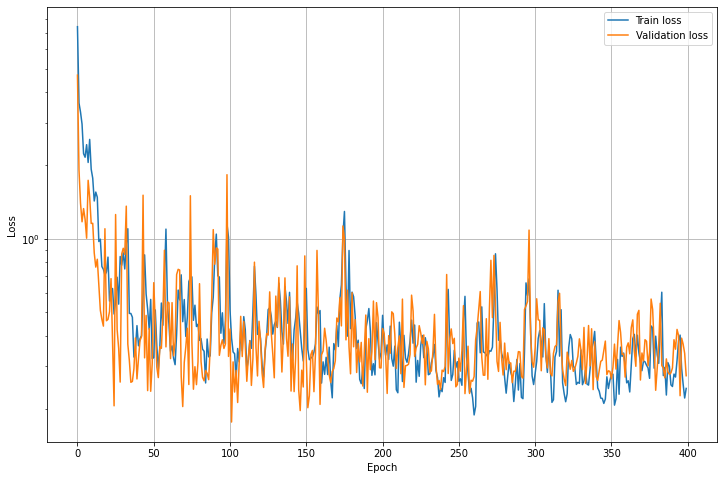

In [103]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

* We see that we can use early stopping, it could be implemented by using skorch (a Scikit-learn wrapper for PyTorch).

## Test

In [104]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_f(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.09623260051012039


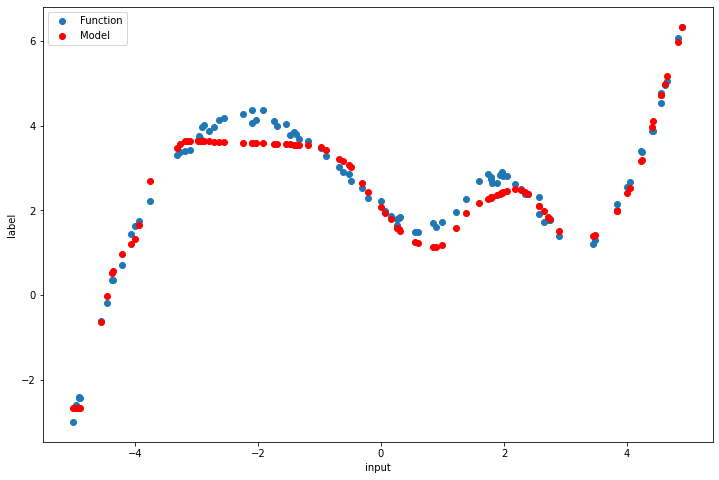

In [105]:
fig = plt.figure(figsize=(12,8))
plt.scatter(all_inputs.squeeze().cpu().numpy(), all_labels.squeeze().cpu().numpy(), label='Function')
plt.scatter(all_inputs.squeeze().cpu().numpy(), all_outputs.squeeze().cpu().numpy(), c='r', label='Model')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

It learned it appears a more complicated function... However the loss is good.

## Network analysis

Network params

In [106]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc3.weight.data.cpu().numpy()
h3_b = net.fc3.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

### Weights histograms

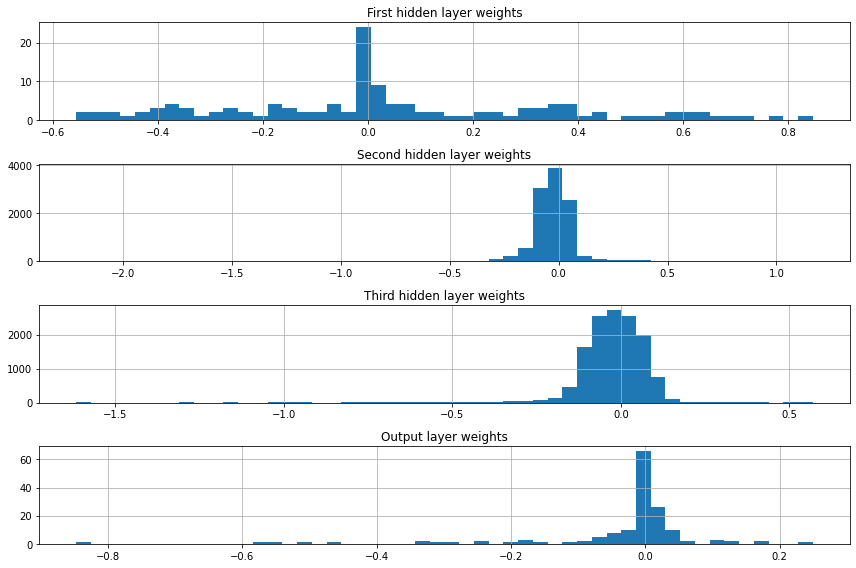

In [107]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Activations profiles

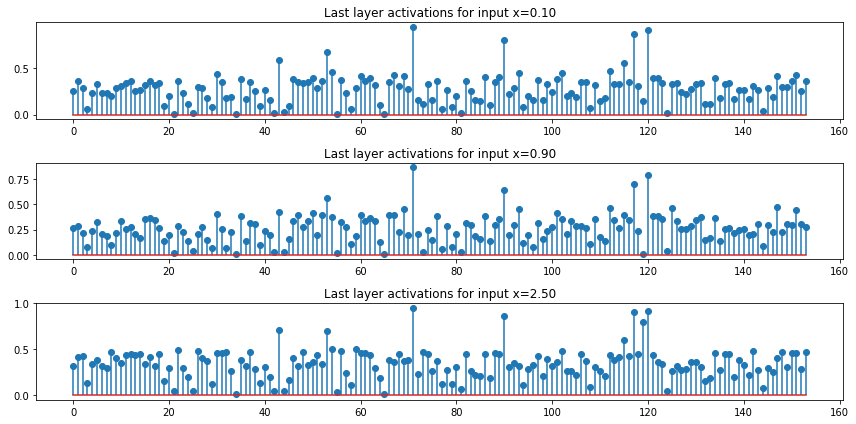

In [109]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc3.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Classification task

**HINTS**
- Choose a loss function that is suitable for the specific problem, a binary classification in this case. If you keep a single linear output you can use a BCEWithLogitsLoss, which is more numerically stable than manually using a sigmoid output activation (more info here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).
- The network now has 2 inputs. A batched input should have a shape $\text{batch_size} \times 2$.
- The dataset should be adapted accordingly. Also consider to increase the batch size.
- Explore different optimizers, trying to understand the differences and their parameters (https://pytorch.org/docs/stable/optim.html).
- Try to increase the complexity of the network, and at the same time to introduce some regularization with dropout layers and/or weight decay (which is equivalent to an L2 regularization, typically implemented by the optimizer).
- Experiment with different hyper-parameters trying to minimize the VALIDATION LOSS. Once you are happy with the result, try the final test with the TEST dataset.

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, activation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [110]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

### Loading data

Download the dataset:

In [93]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

In [111]:
from torchvision import transforms

In [112]:
train_dataset_tensor = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=transforms.Compose([
    torchvision.transforms.ToTensor(),
]))
test_dataset_tensor  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=transforms.Compose([
    torchvision.transforms.ToTensor(),
]))

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



The Tensors are already normalized, but the data and targets are not.

How to get an image and the corresponding label:


SAMPLE AT INDEX 0
LABEL: 5


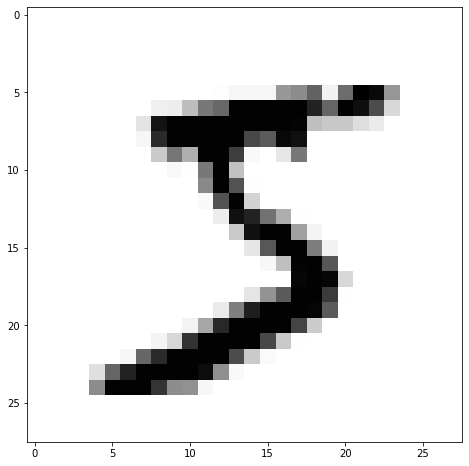

In [ ]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


### Performing train test split

The train dataset is 60k samples, the test - 10k. Validation data could be ~10k.

In [113]:
from sklearn.model_selection import train_test_split

**For a simple classifier**

This way we get separate data and targets for train and val which are Tensors

In [116]:
train_tensor, val_tensor = train_test_split(train_dataset_tensor, test_size=0.17, random_state=np.random.seed(42))

In [117]:
len(train_tensor), len(val_tensor)

(49800, 10200)

Loading and splitting altogether:

In [115]:
import torchvision
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def get_data():
    train_dataset_tensor = torchvision.datasets.MNIST('classifier_data', train=True, download=True, transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
    ]))
    test_dataset_tensor  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
    ]))
    test_dataset_tensor  = torchvision.datasets.MNIST('classifier_data', train=False, download=True, transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
    ]))
    train_tensor, val_tensor = train_test_split(train_dataset_tensor, test_size=0.17, random_state=np.random.seed(42))
    train_dataloader_tensor = DataLoader(train_tensor, batch_size=200, shuffle=True, num_workers=0)
    val_dataloader_tensor   = DataLoader(val_tensor, batch_size=len(val_tensor), shuffle=False, num_workers=0)
    test_dataloader_tensor  = DataLoader(test_dataset_tensor,  batch_size=len(test_dataset_tensor), shuffle=False, num_workers=0)
    return train_dataloader_tensor, val_dataloader_tensor, test_dataloader_tensor, test_dataset_tensor

**For a CNN**

This way we get a list of tuples containing a PIL Image and a corresponding label for train and val

In [ ]:
train, val = train_test_split(train_dataset, test_size=0.17)

In [ ]:
train[:5]

[(<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D70940>, 8),
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D707F0>, 7),
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D70048>, 9),
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D70F98>, 0),
 (<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D70160>, 0)]

In [ ]:
from torchvision import transforms

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

**From PIL Image to Tensor for a simple classifier (alternatively)**

Takes too long

In [ ]:
Xy_train = [(to_tensor(x), y) for x, y in train]
Xy_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
Xy_val = [(to_tensor(x), y) for x, y in val]
Xy_val[0][0].shape

torch.Size([1, 28, 28])

We already have Tensors and PIL Images, so no need to save .csv and convert to Tensor using Dataset.

### DataLoader

In [118]:
from torch.utils.data import DataLoader

Dataset is not needed (already values of appropriate type), just define the dataloaders

Simple classifier working with Tensors

In [119]:
train_dataloader_tensor = DataLoader(train_tensor, batch_size=200, shuffle=True, num_workers=0)
val_dataloader_tensor   = DataLoader(val_tensor, batch_size=len(val_tensor), shuffle=False, num_workers=0)
test_dataloader_tensor  = DataLoader(test_dataset_tensor,  batch_size=len(test_dataset_tensor), shuffle=False, num_workers=0)

CNN working with PIL Images

In [ ]:
train_dataloader = DataLoader(train, batch_size=200, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val, batch_size=len(val), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
train_dataloader.dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F00F7D70940>, 8)

In [2]:
train_dataloader_tensor, val_dataloader_tensor, test_dataloader_tensor, test_dataset_tensor = get_data()

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Use Optuna

Here is the code for both MLP and CNN

In [ ]:
!pip install optuna

In [ ]:
import optuna

Both

In [ ]:
BATCHSIZE = 200

n_classes = 10
DEVICE = device
EPOCHS = 30
LOG_INTERVAL = 10

N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

MLP

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    #n_layers = trial.suggest_int("n_layers", 2, 3)
    n_layers = 2
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 64, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Sigmoid())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, n_classes))

    return nn.Sequential(*layers)

CNN

In [ ]:
def define_conv_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    #n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_channels = 1
    for i in range(2):
        out_channels = trial.suggest_int("n_units_conv_l{}".format(i), 3, 64)
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3))
        if i == 1:
            p = trial.suggest_float("dropout_conv2_l{}".format(i), 0.1, 0.4)
            layers.append(nn.Dropout2d(p))
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.Sigmoid())
        in_channels = out_channels

    in_features = in_channels * 5 * 5
    layers.append(nn.Flatten())
    #print(in_channels, in_features)
    for i in range(1):
        out_features = trial.suggest_int("n_units_l{}".format(i), 64, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.Sigmoid())
        p = trial.suggest_float("dropout_l{}".format(i), 0.3, 0.7)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, n_classes))

    return nn.Sequential(*layers)

MLP

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Get the MNIST dataset.
    train_loader, valid_loader = train_dataloader_tensor, val_dataloader_tensor

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

CNN

In [ ]:
def objective(trial):

    # Generate the model.
    model = define_conv_model(trial).to(DEVICE)

    # Generate the optimizers.
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
    #optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Get the MNIST dataset.
    train_loader, valid_loader = train_dataloader_tensor, val_dataloader_tensor

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

Both

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-02-24 16:51:47,405] A new study created in memory with name: no-name-41b74cd1-7f36-4cb5-b5ba-c64f816164dc
[I 2021-02-24 16:51:56,595] Trial 0 finished with value: 0.5585 and parameters: {'n_units_conv_l0': 16, 'n_units_conv_l1': 60, 'dropout_conv2_l1': 0.3486791309681112, 'n_units_l0': 104, 'dropout_l0': 0.4702221440626394, 'lr': 0.06040193356796468}. Best is trial 0 with value: 0.5585.
[I 2021-02-24 16:52:10,068] Trial 1 finished with value: 0.5585 and parameters: {'n_units_conv_l0': 61, 'n_units_conv_l1': 36, 'dropout_conv2_l1': 0.11735002604148834, 'n_units_l0': 88, 'dropout_l0': 0.38483313181851536, 'lr': 0.006933352412878271}. Best is trial 0 with value: 0.5585.
[I 2021-02-24 16:52:21,161] Trial 2 finished with value: 4.703 and parameters: {'n_units_conv_l0': 47, 'n_units_conv_l1': 14, 'dropout_conv2_l1': 0.32890870158717744, 'n_units_l0': 113, 'dropout_l0': 0.5275731807402292, 'lr': 0.0017667260295014613}. Best is trial 2 with value: 4.703.
[I 2021-02-24 16:52:29,160] Tri

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  89
  Number of complete trials:  11
Best trial:
  Value:  4.9405
  Params: 
    n_units_conv_l0: 11
    n_units_conv_l1: 58
    dropout_conv2_l1: 0.13290258827010132
    n_units_l0: 70
    dropout_l0: 0.4357182475644815
    lr: 0.0031536138297536317


### Visualize

In [ ]:
trial.distributions.keys()

dict_keys(['n_units_conv_l0', 'n_units_conv_l1', 'dropout_conv2_l1', 'n_units_l0', 'dropout_l0', 'lr'])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study, ['n_units_conv_l1'])

In [ ]:
optuna.visualization.plot_contour(study, ['n_units_l1', 'dropout_l1'])

This allows us to decide the configuration; just use the model for the best trial.

## Network definition

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In the end such configuration produces better results. We also flatten the data because here we do not train a CNN yet. And for this data Sigmoid works better as an activation.

In [7]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout1=0.2, dropout2=0.49):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x, additional_out=False):
        x = x.view(x.shape[0], -1)
        x = self.act(self.fc1(x))
        x = self.dropout1(x)
        x = self.act(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return x

## Training loop

In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Check if a cuda GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


Added adjusting learning rate using Scheduler. It lets us avoid gradient descent with a too big "speed".

In [67]:
# Initialize the network
torch.manual_seed(0)
Ni = 28 * 28
Nh1 = 213 #128
Nh2 = 150 #239 #256
No = 10
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-2) #, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

Network initialized


Be careful about dimensions: the sampled batch was of shape (200, 1, 28, 28) while we expect that of (200, 28 * 28).

In [12]:
import matplotlib.pyplot as plt

In [37]:
def train_val(net, loss_fn, optimizer, num_epochs=20):
  ### TRAINING LOOP
  #num_epochs = 200 #600
  train_loss_log = []
  val_acc_log = []
  val_loss_log = []
  for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader_tensor:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    correct = 0
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in val_dataloader_tensor:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

        # Get the index of the max log-probability.
        pred = out.argmax(dim=1, keepdim=True)
        correct += pred.eq(label_batch.view_as(pred)).sum().item()

      accuracy = correct / len(val_dataloader_tensor.dataset)
      print(f"VAL ACCURACY: {accuracy}")
      val_acc_log.append(accuracy)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)

      scheduler.step(val_loss)

  return train_loss_log, val_acc_log, val_loss_log

In [68]:
train_loss_log, val_acc_log, val_loss_log = train_val(net, loss_fn, optimizer, num_epochs=30)

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.462789386510849
VAL ACCURACY: 0.9477450980392157
AVERAGE VAL LOSS: 0.16659732162952423
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.16976717114448547
VAL ACCURACY: 0.9637254901960784
AVERAGE VAL LOSS: 0.11473401635885239
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.12735222280025482
VAL ACCURACY: 0.9695098039215686
AVERAGE VAL LOSS: 0.09691181033849716
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.10523631423711777
VAL ACCURACY: 0.9716666666666667
AVERAGE VAL LOSS: 0.09092289209365845
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.09954214841127396
VAL ACCURACY: 0.9722549019607843
AVERAGE VAL LOSS: 0.0927155464887619
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.08445185422897339
VAL ACCURACY: 0.9740196078431372
AVERAGE VAL LOSS: 0.08826147019863129
#################
# EPOCH 6
#################
AVERAGE TRAIN L

The accuracy of last half of epochs

In [69]:
np.mean(val_acc_log[round(len(val_acc_log)/2):])

0.9804575163398693

Configuration

In [81]:
net

Net(
  (fc1): Linear(in_features=784, out_features=213, bias=True)
  (fc2): Linear(in_features=213, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=10, bias=True)
  (act): Sigmoid()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.49, inplace=False)
)

### Plot acc, loss

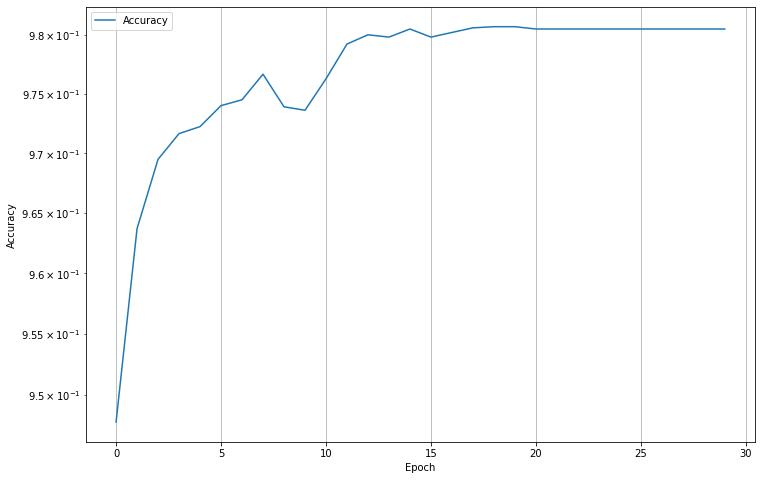

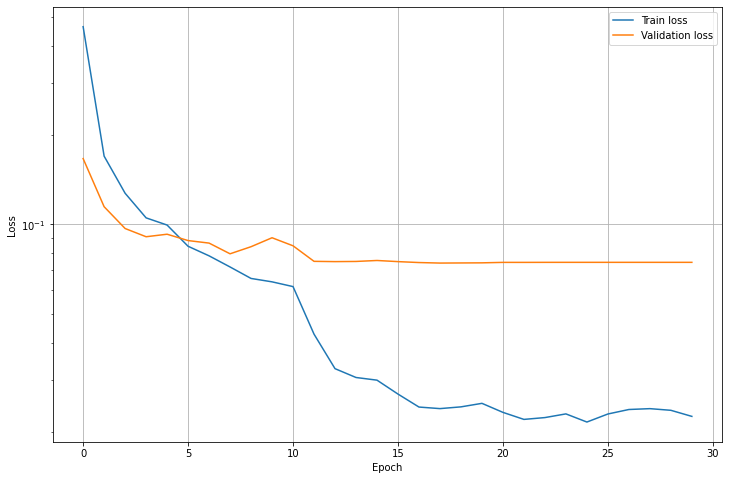

In [70]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(val_acc_log, label='Accuracy')
#plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Test accuracy

Test loss

In [71]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader_tensor:
    # Move data to device
    x_batch = sample_batched[0].view(sample_batched[0].shape[0], -1).to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.07438018918037415


In [72]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes = all_outputs.argmax(dim=1)

Test accuracy

In [73]:
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 98.13%


Accuracy of identifying correctly previously misclassified test samples

In [74]:
tot_correct_out = (all_output_classes[error_mask] == all_labels[error_mask]).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels[error_mask])
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 30.69%


For plotting digit images

In [21]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

Previously misidentified now are... some classified correctly.

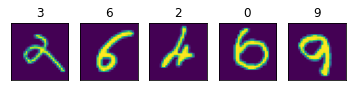

In [75]:
### Plot
y_pred = all_output_classes.squeeze().cpu().numpy()

# Mark wrong outputs
plot_example(test_dataset_tensor.data[error_mask].view(-1, 784), y_pred[error_mask])

The ones that the net did not get right. Saving error mask.

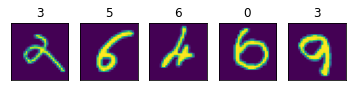

In [46]:
### Plot
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

# Mark wrong outputs
error_mask = y_pred != y_true
plot_example(test_dataset_tensor.data[error_mask].view(-1, 784), y_pred[error_mask])

## CNN

Let us try to improve the metrics with another architecture - a CNN. We already ran Optuna code for optimizing the hyperparams, so now we implement the chosen configuration.

In [109]:
class CNet(nn.Module):
    
    def __init__(self, Ni, Nh1, No, Nc1, Nc2, dropout=0.5, dropout_conv=0.25):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.conv1 = nn.Conv2d(1, Nc1, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(Nc1, Nc2, kernel_size=3)
        self.conv2_dropout = nn.Dropout2d(dropout_conv)
        self.fc1 = nn.Linear(in_features=Nc2 * 5 * 5, out_features=Nh1)
        self.out = nn.Linear(in_features=Nh1, out_features=No)
        self.act = nn.Sigmoid()
        self.dropout1d = nn.Dropout(dropout)
        
    def forward(self, x, additional_out=False):
        #print("input", x.shape)
        x = self.pool(self.act(self.conv1(x)))
        #print("pool(conv1)", x.shape)
        x = self.pool(self.act(self.conv2_dropout(self.conv2(x))))
        #print("pool(conv1)", x.shape)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        #print("flatten", x.shape)
        x = self.act(self.fc1(x))
        #print("fc1", x.shape)
        x = self.out(x)
        #print("output", x.shape)
        return x

In [155]:
# Initialize the network
torch.manual_seed(0)
Ni = 64 * 5 * 5
Nh1 = 128
No = 10
Nc1 = 11
Nc2 = 64
net = CNet(Ni, Nh1, No, Nc1, Nc2, dropout_conv=0.15)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=3e-3) #, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

Network initialized


In [156]:
train_loss_log, val_acc_log, val_loss_log = train_val(net, loss_fn, optimizer, num_epochs=30)

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 1.626228928565979
VAL ACCURACY: 0.9146078431372549
AVERAGE VAL LOSS: 0.3150206208229065
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.19950535893440247
VAL ACCURACY: 0.9641176470588235
AVERAGE VAL LOSS: 0.13044901192188263
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.11639929562807083
VAL ACCURACY: 0.9726470588235294
AVERAGE VAL LOSS: 0.09183117002248764
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.09097318351268768
VAL ACCURACY: 0.9772549019607844
AVERAGE VAL LOSS: 0.07757388800382614
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.07366354763507843
VAL ACCURACY: 0.9798039215686275
AVERAGE VAL LOSS: 0.06568461656570435
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.06537864357233047
VAL ACCURACY: 0.9805882352941176
AVERAGE VAL LOSS: 0.06416250765323639
#################
# EPOCH 6
#################
AVERAGE TRAIN L

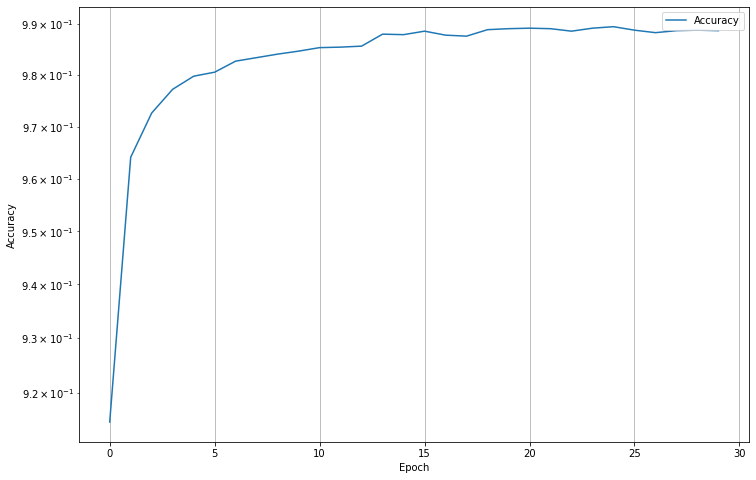

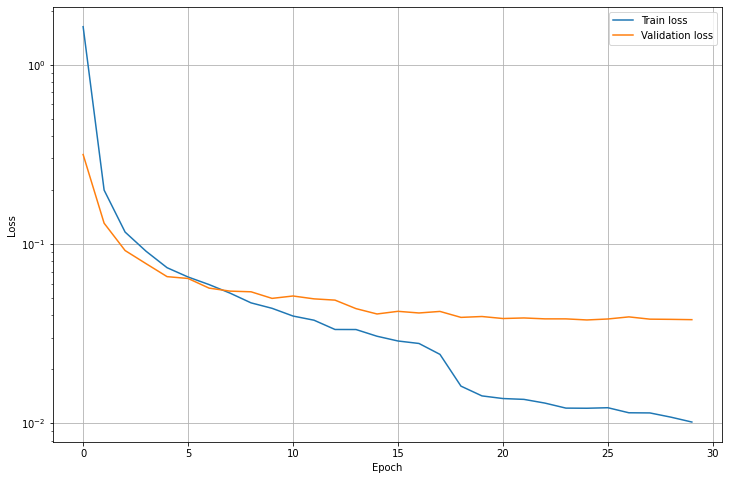

In [157]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(val_acc_log, label='Accuracy')
#plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Acc on Test

Test loss is much better; the MLP could hardly overcome the 0.07 threshold. So we understand that the data demands suitable model implementation.

In [158]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
  for sample_batched in test_dataloader_tensor:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
# Concatenate all the outputs and labels ina single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.03175907954573631


The accuracy improved! The best I got is 98.91%

In [159]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes = all_outputs.argmax(dim=1)
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 98.89%


Accuracy of identifying correctly of previously misclassified test samples was 61% for the CNN compared to MLP. CNNs among each other have 30-36%

In [160]:
tot_correct_out = (all_output_classes[error_mask] == all_labels[error_mask]).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels[error_mask])
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 35.78%


Correctly identified the 9.

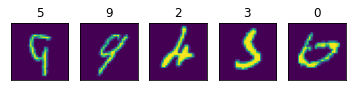

In [161]:
### Plot
y_pred = all_output_classes.squeeze().cpu().numpy()

# Mark wrong outputs
plot_example(test_dataset_tensor.data[error_mask].view(-1, 784), y_pred[error_mask])

But misclassified 4.

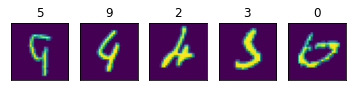

In [162]:
### Plot
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

# Mark wrong outputs
error_mask = y_pred != y_true
plot_example(test_dataset_tensor.data[error_mask].view(-1, 784), y_pred[error_mask])

## Network analysis

Network params

In [122]:
net

CNet(
  (conv1): Conv2d(1, 11, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_dropout): Dropout2d(p=0.15, inplace=False)
  (fc1): Linear(in_features=1600, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
  (act): Sigmoid()
  (dropout1d): Dropout(p=0.5, inplace=False)
)

In [139]:
# First convolutional layer
c1_w = net.conv1.weight.data.cpu().numpy()
c1_b = net.conv1.bias.data.cpu().numpy()

# Second convolutional layer
c2_w = net.conv2.weight.data.cpu().numpy()
c2_b = net.conv2.bias.data.cpu().numpy()

# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

### Weights histograms

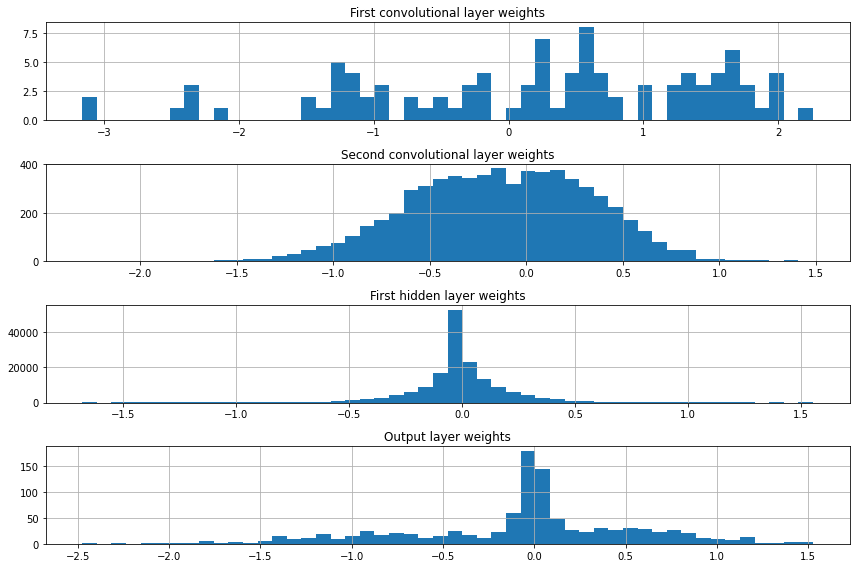

In [141]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First convolutional layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Second convolutional layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Receptive fields

In [125]:
!git clone https://github.com/Fangyh09/pytorch-receptive-field.git

Cloning into 'pytorch-receptive-field'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 53 (delta 0), reused 2 (delta 0), pack-reused 48
Unpacking objects: 100% (53/53), done.


In [131]:
cd pytorch-receptive-field/torch_receptive_field

/content/pytorch-receptive-field/torch_receptive_field


In [132]:
from receptive_field import receptive_field

In [137]:
receptive_field_dict = receptive_field(net, (1, 28, 28))

KeyError: ignored

In [133]:
receptive_field_dict = receptive_field(net, (1, 28, 28))
receptive_field_for_unit(receptive_field_dict, "2", (2,2))

ValueError: ignored

Some error... Should find some other way to visualize receptive fields